# Thesis Code
- This is the code used to create the final results for the thesis.
- It uses components from all the other notebooks.
- It is only the final, simple version.

## 0) Initialize and Load Data

### 0.1) Import Libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from toolz import *

from scipy.special import expit
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

import warnings
# Suppress the RuntimeWarning related to the log operation
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log")
# Suppress the RuntimeWarning related to divide by zero encountered in log
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in log")

# Import my homegrown functions
from functions import *

import os
import sys
from datetime import datetime

### 0.2) Load Data

In [2]:
# df_og = pd.read_csv('data/merged_all.csv')
df_og = pd.read_csv('data/merged_all_28_8_2023.csv')

# Read the Excel file and get the specified sheets as dataframes
file_path = "data/questionaire_activities_sectors_industries.xlsx"
sheet_names = ["2022", "2021", "2020", "2019", "2018"]

df_questionaire_industry = pd.read_excel(file_path, sheet_name=sheet_names)

# Concatenate all dataframes into one
industry_df = pd.concat(df_questionaire_industry.values(), ignore_index=True)

# Keep only the unique rows based on the "account_id" column
industry_df = industry_df.drop_duplicates(subset=['account_id'])

# Keep only the desired columns
industry_df = industry_df[['account_id', 'activity', 'sector', 'industry']]
industry_df.head()

industry_df.dropna(subset=['industry'],inplace=True)

df_og = df_og.merge(industry_df, on=['account_id'], how='left')

print('This dataset has: ',df_og['account_id'].nunique(), ' unique accounts.')

This dataset has:  4045  unique accounts.


### 0.3) Preprocess Data

In [3]:
df = df_og.copy()

df['ICP_applied']=df['icp_binary'].fillna(0)

# Drop some columns that are not needed
collumns_to_drop = ['Unnamed: 0','instrument_x','instrument_y','op_profit','roa_actual', 'book_value',
                    'energy2EVIC', 'icp_short', 'c02_per_size', 'log_c02_per_size','CUSIP', 
                    'country_exchange',  'sic_name', 'sic_code', 'sic_industry','energy_per_size', 
                    'log_energy_per_size','c02_employee_intensity', 'log_c02_employee_intensity',
                    'log_energy_total', 'energy_employee_intensity','log_energy_employee_intensity', 
                    'energy_revenue_intensity','log_energy_revenue_intensity','change', 'exited',
                    'log_company_size', 'current_assets_total', 'profit_gross']

df.drop(columns=collumns_to_drop, inplace=True)

# drop all the rows where my main outcome is nan
df.dropna(subset=['c02','industry'],inplace=True)

df['log_c02'] = df['log_c02'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['log_c02'])
df = df[df['c02'] >= 1]

# Columns to be multiplied by 1e-6
columns_to_scale = ['revenue_total', 'debt_long_term', 'liabilities_total', 'assets_total','market_cap']

# Multiply selected columns by 1e-6
df[columns_to_scale] = df[columns_to_scale].apply(lambda x: x * 1e-6)

df = df[df['revenue_total'] >= 1]
df = df[df['liabilities_total'] >= 1]

df['debt_long_term'] += 1e-3

# Define the condition you want to use for dropping rows
condition = (df['industry'] == 'Corporate Tags')

# Use the condition to filter and keep rows that do not meet the condition
df = df[~condition]

# df = df[df['company_size'] >= 1]

df['c02_assets_intensity'] = df['c02'] / df['assets_total']
df['logc02_assets_intensity'] = np.log(df['c02_assets_intensity'])
# df[['c02_assets_intensity','logc02_assets_intensity']].describe()

# Create log variables
df['log_revenue_total'] = np.log(df['revenue_total'])
df['log_debt_long_term'] = np.log(df['debt_long_term'])
df['log_liabilities_total'] = np.log(df['liabilities_total'])
df['log_assets_total'] = np.log(df['assets_total'])
df['log_company_size'] = np.log(df['company_size'])

df['log_revenue_total'] = df['log_revenue_total'].replace([np.inf, -np.inf], np.nan)
df['log_debt_long_term'] = df['log_debt_long_term'].replace([np.inf, -np.inf], np.nan)
df['log_liabilities_total'] = df['log_liabilities_total'].replace([np.inf, -np.inf], np.nan)
df['log_assets_total'] = df['log_assets_total'].replace([np.inf, -np.inf], np.nan)
df['log_company_size'] = df['log_company_size'].replace([np.inf, -np.inf], np.nan)

df = df.dropna(subset=['log_revenue_total','log_debt_long_term','log_liabilities_total','log_assets_total'])

df['shares_strategic_percent'] = (df['shares_strategic'] / df['shares']) * 100 + 0.01

#### Quantiles for revenue and to remove the top and bottom 1% of emitters

- To have the option for categorical revenue.
- To remove the top 1% and bottom 1% of emitters.


In [4]:
# Define the quantiles
quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Calculate the quantiles of 'revenue_total'
quantile_values = df['revenue_total'].quantile(quantiles)

# Create bins based on quantiles
bins = [quantile_values[quantiles[0]]] + list(quantile_values[quantiles[1]:quantiles[-1]]) + [quantile_values[quantiles[-1]]]

# Create labels for the bins
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']

# Create a new categorical variable based on 'revenue_total'
df['revenue_category'] = pd.cut(df['revenue_total'], bins=bins, labels=labels,duplicates='drop')

In [5]:
# Define the quantiles
quantiles = [0, 0.01, 0.99, 1.0]

# Calculate the quantiles of 'revenue_total'
quantile_values = df['log_c02'].quantile(quantiles)

# Create bins based on quantiles
bins = [quantile_values[quantiles[0]]] + list(quantile_values[quantiles[1]:quantiles[-1]]) + [quantile_values[quantiles[-1]]]

# Create labels for the bins
labels = ['bottom_1%', 'mid', 'top_1%']

# Create a new categorical variable based on 'revenue_total'
df['log_c02_category'] = pd.cut(df['log_c02'], bins=bins, labels=labels,duplicates='drop')
df = df[df['log_c02_category'] == 'mid']
# df['log_c02_category'].describe()

#### 0.3.1) Create the column of the year the treatment started

In [6]:
# Create the new column icp_start_year
df['icp_year_active'] = df['year'] * df['ICP_applied']

# Create a new column with the year of the first ICP treatment
# Define a custom lambda function to find the minimum non-zero value in a group
min_non_zero = lambda x: np.min(x[x > 0])
# Group by account_id and use transform to broadcast the minimum non-zero value to each row
df['icp_start_year'] = df.groupby('account_id')['icp_year_active'].transform(min_non_zero)
# Replace NaN values from the companies that have not been treated in icp_start_year with zeros
df['icp_start_year'].fillna(0, inplace=True)

# Drop the temporary column icp_year_active
df.drop(columns=['icp_year_active'], inplace=True)

df['years_from_icp'] = df['year'] - df['icp_start_year']

# df[['icp_start_year','years_from_icp']].describe()

#### 0.3.2) Split in treatment and control groups

In [7]:
# Save the df columns in a list
columns = df.columns
# print(columns)

df_treatment = df[df['treatment']==1]
df_treatment = df_treatment[df_treatment['icp_start_year']>0]
df_control = df[df['treatment']==0]

# Save the initial dataset
# df.to_csv('data/1_Data_Used_in_Thesis.csv', index=False)

# df_treatment[['icp_start_year','years_from_icp']].describe()

#### 0.3.3) Remove the companies treated before 2015 and the ones changed from threatment back to control

In [8]:
df_treated_after2015 = df_treatment[df_treatment['icp_start_year']>2015]
# Sort the DataFrame by account_id and year
df_treated_after2015.sort_values(['account_id', 'year'], inplace=True)

# Create a mask for rows where ICP_applied changes from 0 to 1 and back to 0
df_treated_after2015['ICP_previous'] = df_treated_after2015.groupby('account_id')['ICP_applied'].shift(1)
df_treated_after2015['ICP_next'] = df_treated_after2015.groupby('account_id')['ICP_applied'].shift(-1)
change_mask = (
    (df_treated_after2015['ICP_applied'] == 0) &
    (df_treated_after2015['ICP_previous'] == 1) &
    (df_treated_after2015['ICP_next'] == 0)
)

# Identify the account_ids that meet the criteria
problematic_account_ids = df_treated_after2015.loc[change_mask, 'account_id'].unique()

# Filter the DataFrame to exclude those account_ids
df_filtered = df_treated_after2015[~df_treated_after2015['account_id'].isin(problematic_account_ids)]

C:\Users\ipapazog\AppData\Local\Temp\ipykernel_26752\3976723294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated_after2015.sort_values(['account_id', 'year'], inplace=True)
C:\Users\ipapazog\AppData\Local\Temp\ipykernel_26752\3976723294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated_after2015['ICP_previous'] = df_treated_after2015.groupby('account_id')['ICP_applied'].shift(1)
C:\Users\ipapazog\AppData\Local\Temp\ipykernel_26752\3976723294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [9]:
# Get the unique account IDs that have all three periods (-1, 0, and 1)
valid_account_ids = df_filtered[df_filtered['years_from_icp'].isin([-1, 0, 1])]['account_id'].value_counts()
valid_account_ids = valid_account_ids[valid_account_ids == 3].index

# Filter the original DataFrame to keep only the valid account IDs
df_filtered = df_filtered[df_filtered['account_id'].isin(valid_account_ids)]

In [10]:
collumns_to_drop2=['ICP_next','ICP_previous','icp_binary','project_year',]
df_filtered.drop(columns=collumns_to_drop2, inplace=True)

# drop all the rows where my main outcome is nan
# df_filtered.dropna(subset=['c02','industry'],inplace=True)

In [11]:
df_filtered.sort_values([ 'year'], inplace=True)

# # Some Diagnostics:
# years = df_filtered['year'].unique()
# for year in years:
#     dummy_df_year = df_filtered[df_filtered['year']==year]
#     count = dummy_df_year[dummy_df_year['icp_start_year']==year].shape[0]
#     count_active = dummy_df_year[dummy_df_year['ICP_applied']==1].shape[0]
#     print(f'Number of treated companies in {year}: {count} and active companies: {count_active}')

# for year in years:
#     dummy_df_year = df_filtered[df_filtered['year']==year]
#     count = dummy_df_year[dummy_df_year['icp_start_year']==2018].shape[0]
#     print(f'Number of started icp in 2018 in year {year}: {count} ')

#### 0.3.4) Create a dataframe only for treatments between 2016 and 2022

In [12]:
df_treated_2016to2022 = df_filtered
df_treated_2016to2021 = df_treated_2016to2022[df_treated_2016to2022['icp_start_year']<2022]

df_all_treatment_2016to2021 = df[~df['account_id'].isin(problematic_account_ids)]

print('The pricessed dataset has: ',df_treated_2016to2021['account_id'].nunique(), ' unique accounts.')

The pricessed dataset has:  449  unique accounts.


## 1) Define the functions used

### 1.1) Define the functions used for plotting

In [13]:
# ============================================================================   
# Function to plot missing values per variable
def plot_missing_values(df, title='Missing values per variable', size=(6, 17)	):
    # Calculate the missing value counts for each column
    na_counts = df.isna().sum()
    # Create a long figure
    plt.figure(figsize=size)
    # Create a horizontal bar plot
    plt.barh(na_counts.index, na_counts.values)
    # Customize the plot
    plt.xlabel('Missing Values')
    plt.ylabel('Variables')
    plt.title(title)
    # Display the plot
    plt.show()


### 1.2) Define the functions used for the models

In [14]:
# ============================================================================  
def perform_TWFE(df, outcome_variable='log_c02', control_variables=' ',
                                      print_results=False):

    df['account_id'] = df['account_id'].astype('category')

    formula = f"""{outcome_variable} ~ ICP_applied + {control_variables} + C(year) + C(account_id)"""

    model = smf.ols(formula, data=df).fit()

    ate = model.params['ICP_applied']

    # Display the results
    if print_results:
        print('Outcome: ', outcome_variable)
        
        # print(model.summary())
        print('Total Model Parameters: ', len(model.params))
        print("TWFE pred Effect: ",model.params["ICP_applied"])
        # print("TWFE pred Effect: ", df.query("treated==1").mean())
    else:
        print('ATE basic TWFE: ', round(ate,4))

        
    return model, ate


### 1.3) Define the functions used to save the results table to csv

In [15]:
def save_results2csv(table,file_name,file_path = 'results/'):
    # Check if the file already exists
    
    output_file = file_path + file_name

    if os.path.exists(output_file):
        # Get the current date and time
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # Append the timestamp to the filename
        base_name, extension = os.path.splitext(output_file)
        output_file = f"{base_name}_{timestamp}{extension}"

    table.tables[0].to_csv(output_file)

## 2) Start with some plots to check the missing data

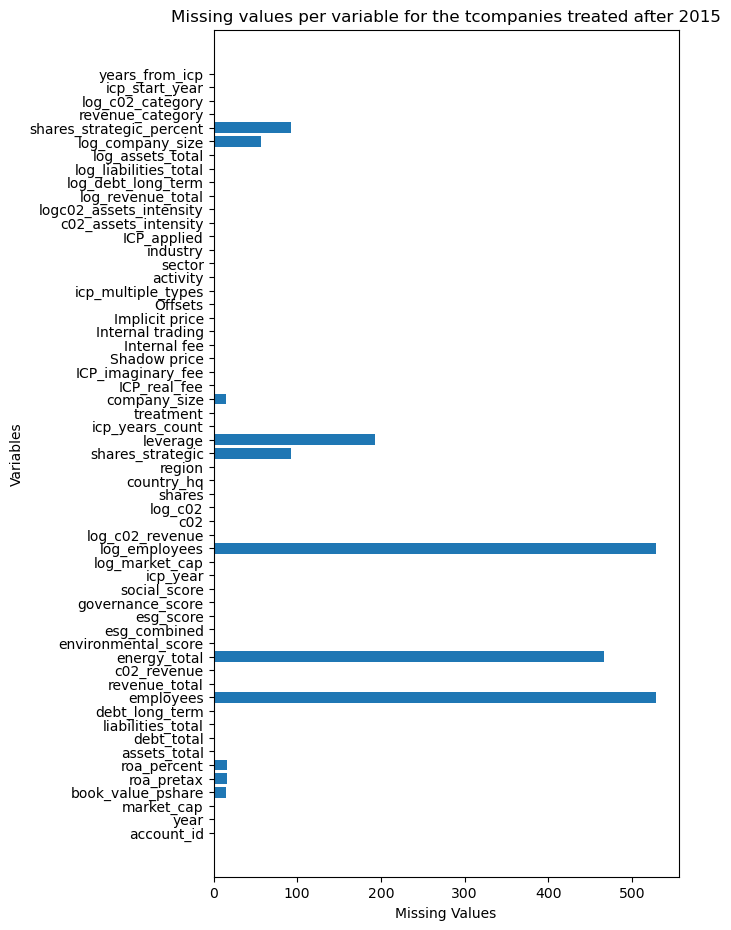

In [17]:
plot_missing_values(df_treated_2016to2021, title='Missing values per variable for the tcompanies treated after 2015',size=(6, 11))

## 3) Create the models

## 3.1) Investigate different covariates

In [18]:
working_df = df_treated_2016to2021.copy()

formula = f"""log_c02 ~ ICP_applied + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_1 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_market_cap + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_2 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + social_score + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_3 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + esg_score + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_4 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied +environmental_score + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_5 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_revenue_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_6 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied +log_debt_long_term + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_7 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied +log_liabilities_total+ C(region):C(year) + C(industry):C(year) + C(account_id) """
results_8 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied +log_assets_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_9 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_market_cap + social_score + esg_score + environmental_score + log_revenue_total + log_debt_long_term + log_liabilities_total + log_assets_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_10 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_revenue_total + log_liabilities_total + log_assets_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_11 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_revenue_total + log_liabilities_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_12 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_revenue_total + log_assets_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_13 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied + log_liabilities_total + log_assets_total + C(region):C(year) + C(industry):C(year) + C(account_id) """
results_14 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

results = [results_1,results_2,results_3,results_4,results_5,results_6,
            results_7,results_8,results_9,results_10,results_11,results_12, results_13, results_14]
model_titles = ['FE baseline','Market Cap','Social','ESG','Environmental Score',
                'Revenue','Debt','Liabilities','Assets','All','Revenue + Liabilities + Assets'
                ,'Revenue + Liabilities','Revenue + Assets','Liabilities + Assets'
                ]

summary_table = summary_col(results, # List of models
                             model_names=model_titles, # Names for the models
                             stars=True, # Add significance stars
                             float_format='%0.3f', # Format for coefficients
                             info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                                        'R-squared': lambda x: "{:.2f}".format(x.rsquared)})

print(summary_table)
# save_results2csv(summary_table,'log_Covariates_Check.csv',file_path = 'results/')

c:\Users\ipapazog\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))



                                                             FE baseline Market Cap   Social     ESG    Environmental Score  Revenue     Debt   Liabilities   Assets     All    Revenue + Liabilities + Assets Revenue + Liabilities Revenue + Assets Liabilities + Assets
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C(account_id)[T.10056]                                       0.225***    0.175***   0.168***  0.179***  0.203***            0.165***  0.226***  0.195***    0.354***  0.228**   0.187***                       0.164***              0.202***         0.329***            
                                                             (0.005)     (0.028)    (0.038)   (0.027)   (0.017)             (0.012)   (0.008)   (0.010)     (0.030)   (0.116)   (0.042)               

### ICP Interactions

In [20]:
working_df = df_treated_2016to2021.copy()

# drop rows with nan values
working_df = working_df.dropna(subset=['revenue_category','region','country_hq','activity'])

# Define the condition you want to use for dropping rows
condition = (working_df['industry'] == 'Corporate Tags')

# Use the condition to filter and keep rows that do not meet the condition
working_df = working_df[~condition]

formula = f"""log_c02 ~ ICP_applied:C(region) + C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_1 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(industry)  + C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_2 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(revenue_category) + C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_3 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(region) + log_liabilities_total + C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_4 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(industry) + log_liabilities_total + C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_5 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(revenue_category) + log_liabilities_total + C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_6 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(region) +log_assets_total+ C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_7 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(industry)  +log_assets_total+ C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_8 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied:C(revenue_category) +log_assets_total+ C(industry):C(year) + C(region):C(year)+  C(account_id)"""
results_9 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

results = [results_1,results_2,results_3,results_4,results_5,results_6,results_7,results_8,results_9]
model_titles = ['Baseline','Baseline','Baseline','Liabilities','Liabilities','Liabilities','Assets','Assets','Assets']

summary_table = summary_col(results, # List of models
                             model_names=model_titles, # Names for the models
                             stars=True, # Add significance stars
                             float_format='%0.3f', # Format for coefficients
                             info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                                        'R-squared': lambda x: "{:.3f}".format(x.rsquared)})

print(summary_table)
# save_results2csv(summary_table,'ICP_Interactions_3models.csv',file_path = 'results/')


                                                             Baseline I Baseline II Baseline III Liabilities I Liabilities II Liabilities III  Assets I Assets II Assets III
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C(account_id)[T.10056]                                       0.236***   0.253***    0.200***     0.204***      0.216***       0.167***        0.364***  0.372***  0.335***  
                                                             (0.017)    (0.004)     (0.020)      (0.020)       (0.010)        (0.019)         (0.022)   (0.028)   (0.039)   
C(account_id)[T.10062]                                       -1.735***  -1.760***   -1.723***    -1.612***     -1.635***      -1.594***       -1.457*** -1.479*** -1.444*** 
                                                             (0.010)    (0.011)     (0.021)      (0.028)       (0.035)        (0.039) 

### Check also for real and immaginary fees

In [23]:
working_df = df_treated_2016to2021.copy()
# drop rows with nan values
working_df = working_df.dropna(subset=['revenue_category','region','country_hq','activity'])

working_df['ICP_Real_applied'] = working_df['ICP_applied']*working_df['ICP_real_fee']
working_df['ICP_immaginary_applied'] = working_df['ICP_applied']*working_df['ICP_imaginary_fee']


formula = f"""log_c02 ~ ICP_applied+ C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_1 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_Real_applied + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_2 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_immaginary_applied + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_3 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_Real_applied*ICP_immaginary_applied + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_4 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied+ log_liabilities_total+C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_5 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_Real_applied +log_liabilities_total+ C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_6 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_immaginary_applied +log_liabilities_total+ C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_7 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_Real_applied*ICP_immaginary_applied +log_liabilities_total+ C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_8 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_applied+ log_assets_total + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_9 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_Real_applied + log_assets_total + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_10 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_immaginary_applied + log_assets_total + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_11 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)

formula = f"""log_c02 ~ ICP_Real_applied*ICP_immaginary_applied + log_assets_total + C(industry):C(year) + C(region):C(year)+  C(account_id) """
results_12 = smf.ols(formula, data=working_df).fit(
    cov_type="cluster", cov_kwds={"groups": working_df["industry"]}
)


results = [results_1,results_2,results_3,results_4,results_5,results_6,results_7,results_8,results_9,results_10,results_11,results_12]
model_titles = ['baseline','baseline','baseline','baseline','liabilities','liabilities','liabilities','liabilities','assets','assets','assets','assets']

summary_table = summary_col(results, # List of models
                             model_names=model_titles, # Names for the models
                             stars=True, # Add significance stars
                             float_format='%0.3f', # Format for coefficients
                             info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                                        'R-squared': lambda x: "{:.3f}".format(x.rsquared)})

print(summary_table)
# save_results2csv(summary_table,'REAL_AND_IMMAGINARY_covariates.csv',file_path = 'results/')

c:\Users\ipapazog\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))



                                                             baseline I baseline II baseline III baseline IIII liabilities I liabilities II liabilities III liabilities IIII  assets I assets II assets III assets IIII
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C(account_id)[T.10056]                                       0.225***   0.215***    0.214***     0.215***      0.195***      0.182***       0.180***        0.181***         0.354***  0.342***  0.339***   0.340***   
                                                             (0.005)    (0.004)     (0.015)      (0.014)       (0.010)       (0.009)        (0.017)         (0.015)          (0.030)   (0.030)   (0.036)    (0.036)    
C(account_id)[T.10062]                                       -1.745***  -1.744***   -1.732***    -1.741***     -1.622***     -1.618*** 